# *Canadian Mining Stock Chart Analysis*

Looking at the correlation and events for stocks within each mining category

### BETAZERO CAPITAL CONFIDENTIAL
 
### 2019 BetaZero Capital
### All Rights Reserved.
 
 ###### *NOTICE*:  
All information contained herein is, and remains the property of BetaZero Capital and its suppliers. The intellectual and technical concepts contained herein are proprietary to BetaZero Capital Incorporated and its suppliers and may be covered by U.S. and Foreign Patents, patents in process, and are protected by trade secret or copyright law. Dissemination of this information or reproduction of this material is strictly forbidden unless prior written permission is obtained from BetaZero Capital.


In [1]:
import get_stock_data

In [39]:
d = get_stock_data.resource_data_list(['A'])

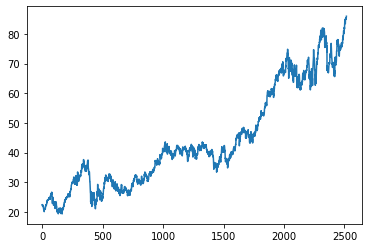

In [41]:
d['A']['Close'].plot()

In [1]:
# Package Imports
import os
import time


import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


from matplotlib import cm as CM
from mpl_finance import candlestick_ohlc # Extends matplot for financial plotting: pip install mpl-finance 
from datetime import datetime
from pandas_datareader import data as pddr # Returns historical stock information: pip install pandas-datareader
from sklearn import preprocessing # used for normalizing data

# Statistical tests
from statsmodels.tsa.stattools import coint, adfuller, grangercausalitytests

# Customed version of https://github.com/jasonstrimpel/volatility-trading
from volatility import voldata, volgrapher

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# SET TO YOUR OWN
ROOT = '/Users/j/Desktop/research/'


## The purpose of the below is unclear but it was part of the mpl_finance setup. ##

# matplotlib.use('Agg') # Bypass the need to install Tkinter GUI framework
# Avoid FutureWarning: Pandas will require you to explicitly register matplotlib converters.
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

In [9]:
# Loads the TSX mining exchange excel sheet and pulls tickers within each industry

tsx_cols = ['Index','Exchange', 'Name', 'Ticker', 'QMV_C$', 'OS_Shares', 'Sector', 'Sub_Sector','Listing',
            'Initial_Listing_Date','HQ_Region','Interlisted_Code','Interlisted_Code_Second','Listed_OTC',
            'TSX_Venture_Grad', 'Former_CPC','Index','City','State','Asia_Region','Country_of_Incorporation',
            'SP_Grouping','SP_Sub','Volume_YTD','Value_YTD_C$','Number_Trades_YTD','Number_Months_Trading_Data',
            'Africa','AUS_NZ_PNG','Canada','China_Asia','Latin_America','Other','UK_Europe','USA',
            'Oil_Gas','Gold','Silver','Copper','Nickel','Diamond','Molybdenum','Platinum','Platinum_PGM',
            'Iron','Lead','Zinc','Rare_Earth','Potash','Lithium','Uranium','Coal','Tungsten',
            'Base_Precious_Metals','Mineral_Properties','Other_Properties']

df_tsx_RAW = pd.read_excel('/Users/j/Desktop/research/MiningThesis/mining-companies-listed-on-tsx-and-tsxv-2019-10-29-en.xlsx',sheet_name='TSX MM Issuers September 2019',names=tsx_cols)
df_tsx = df_tsx_RAW

# Loads the S&P 500 company list and financial information

df_sp = pd.read_csv(ROOT+'s-and-p-500-companies-financials_zip/data/constituents_csv.csv',
                      header='infer')

# List of all public companies
sp_tickers = list(df_sp['Symbol'])

tickers_FIX = list(df_tsx['Ticker'])

for i in range(len(tickers_FIX)):
    tickers_FIX[i] = tickers_FIX[i] + '.TO'
df_tsx['Ticker'] = tickers_FIX
df_tsx.loc[:, 'Oil_Gas':'Mineral_Properties'] = df_tsx.loc[:, 'Oil_Gas':'Mineral_Properties'].fillna(False).replace(1, True)
minerals = tsx_cols[tsx_cols.index('Oil_Gas'):tsx_cols.index('Base_Precious_Metals')]



# List of all public company tickers within each of the following industry
oil_gas_tickers = list(df_tsx[df_tsx.Oil_Gas == True]['Ticker'])
gold_tickers = list(df_tsx[df_tsx.Gold]['Ticker'])
silver_tickers = list(df_tsx[df_tsx.Silver]['Ticker'])
copper_tickers = list(df_tsx[df_tsx.Copper]['Ticker'])
nickel_tickers = list(df_tsx[df_tsx.Nickel]['Ticker'])
diamond_tickers = list(df_tsx[df_tsx.Diamond]['Ticker'])
molybdenum_tickers = list(df_tsx[df_tsx.Molybdenum]['Ticker'])
platinum_tickers = list(df_tsx[df_tsx.Platinum_PGM]['Ticker'])
iron_tickers = list(df_tsx[df_tsx.Iron]['Ticker'])
lead_tickers = list(df_tsx[df_tsx.Lead]['Ticker'])
zinc_tickers = list(df_tsx[df_tsx.Zinc]['Ticker'])
rareearth_tickers = list(df_tsx[df_tsx.Rare_Earth == True]['Ticker'])
potash_tickers = list(df_tsx[df_tsx.Potash]['Ticker'])
lithium_tickers = list(df_tsx[df_tsx.Lithium]['Ticker'])
uranium_tickers = list(df_tsx[df_tsx.Uranium]['Ticker'])
coal_tickers = list(df_tsx[df_tsx.Coal]['Ticker'])
tungsten_tickers = list(df_tsx[df_tsx.Tungsten]['Ticker'])



In [29]:
def add_normalized_close(df):
    # Create x, where x the 'scores' column's values as floats
    x = df[['Adj Close']].values.astype(float)

    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x)

    # Run the normalizer on the dataframe
    df['Normalized Close'] = x_scaled
    
    return df

In [30]:
def get_existing_tickers():
    lst = []
    basepath = ROOT + 'Daily'
    for entry in os.listdir(basepath):
        if os.path.isfile(os.path.join(basepath, entry)):
            lst.append(entry)
            
    return lst

In [41]:
def resource_data_list(lst, start='2010-1-1', end='2020-1-1',):
    data = {}
    
    existing_tickers = get_existing_tickers()
    
    for ticker in lst:
        try:
            if ticker + '.csv' in existing_tickers:
                data[ticker] = pd.read_csv(ROOT + 'Daily/' + ticker + '.csv')

            else:
                stock = pddr.DataReader(ticker, 
                               start=start, 
                               end = end,
                               data_source='yahoo')

                stock = add_normalized_close(stock)
                data[ticker] = stock

                stock.to_csv(ROOT + 'Daily/' + ticker + '.csv' )
        except:
            print("Error: ", ticker)
            
            
        
    return data
    

In [42]:
def add_volatility_measures(stock_dict, estimator='YangZhang', window=30, quantiles = [0.25, 0.75]):

    # Other Estimators
    estimator_list = [
    'GarmanKlass',
    'HodgesTompkins',
    'Kurtosis',
    'Parkinson',
    'Raw',
    'RogersSatchell',
    'Skew',
    'YangZhang'
    ]
    
    
    # volatiltiy functions available
    
    # vol.rolling_quantiles(window=window, quantiles=quantiles)
    # vol.rolling_extremes(window=window)
    # vol.rolling_descriptives(window=window)
    # vol.histogram(window=window, bins=bins, normed=normed)
    # vol.benchmark_compare(window=window)
    # vol.benchmark_correlation(window=window)
    
    #new_dict = {}
    
    for ticker in stock_dict.keys():
        # format for vol package
        temp_stock = stock_dict[ticker]
        temp_stock.symbol = ticker
        
        # initialize class
        vol = voldata.VolatilityEstimator(
            price_data=temp_stock,
            estimator=estimator,
            #bench_data=spx_price_data
        )
        
        vol_descriptives = vol.rolling_descriptives(window=window)
        vol_minmax = vol.rolling_extremes(window=window)
        
        # change the dataframe within the ticker dict
        
        #stock_dict[ticker]['Date '] = vol_descriptives['Date']
        #print(vol_descriptives['Realized'])
        stock_dict[ticker]['Realized Vol [' + str(window) + ']'] = vol_descriptives['Realized']
        stock_dict[ticker]['Rolling Vol [' + str(window) + '] Mean'] = vol_descriptives['Mean']
        stock_dict[ticker]['Rolling Vol [' + str(window) + '] Std'] = vol_descriptives['Std']
        stock_dict[ticker]['Rolling Vol [' + str(window) + '] Z-Score'] = vol_descriptives['Zscore']
        stock_dict[ticker]['Rolling Vol [' + str(window) + '] Max'] = vol_minmax['Max']
        stock_dict[ticker]['Rolling Vol [' + str(window) + '] Min'] = vol_minmax['Min']
        
    
        

In [43]:
def remove_unshared_dates(values):
    min_length =  len(values[0])
    for lst in values[1:]:
        if len(lst) < min_length:
            min_length = len(lst)
            
    for i in range(len(values)):
        values[i] = values[i][-1 * min_length:]
        
    return values

In [44]:
def correlate_stocks(data, column='Close'):
    values = []
    labels = []
    for key in data.keys():
        labels.append(key)
        values.append(list(data[key][column].dropna()))
    values = remove_unshared_dates(values)
    # Only gets rows starting at the most recent common date amongst stocks
        
    corr = np.corrcoef(values)
    
    return (corr, labels)

In [45]:
def cointegrate_stocks(data, column='Close'):
    labels = []
    for key in data.keys():
        labels.append(key)
        
    #values = remove_unshared_dates(values)
    
    pvalue_matrix = np.zeros(shape=(len(labels),len(labels)))
    score_matrix = np.zeros(shape=(len(labels),len(labels)))
    
    for i, x in enumerate(labels):
        for j, y in enumerate(labels):
            if x == y:
                score = None
                pvalue = 0
                
            else:
                lst = [data[x][column].dropna(), data[y][column].dropna()]
                lst = remove_unshared_dates(lst)
                
                score, pvalue, _ = coint(lst[0], lst[1])
            pvalue_matrix[i,j] = pvalue
            score_matrix[i,j] = score
    
    return (pvalue_matrix, score_matrix, labels)

In [46]:
# replaces upper triangle values with nan. Option to delete the corr 1 values for identical correlation pairs
def mask_corr_matrix(corr, del_same_corr=False):

    if del_same_corr:
        count = 0
        #corr = np.delete(corr,1,0)
        corr = np.delete(corr,1,1)
        while count < len(corr):
            corr[count][count + 1:] = [None]*(len(corr) - (count + 1))
            count = count + 1
        
    else:
        count = 0
        while count < len(corr):
            corr[count][count + 1:] = [None]*(len(corr) - (count + 1))
            count = count + 1
    
    
    return corr

In [122]:
def corr_matrix_heatmap(corr, labels, maskSameCorr=False):
    sns.heatmap(mask_corr_matrix(corr, maskSameCorr), center=-1,cmap="YlGnBu",
            square=True, annot=True, linewidths=2,xticklabels=labels,yticklabels=labels, cbar_kws={"shrink": .7})
    size = round(len(labels) / 1.3)
    sns.set(font_scale=0.7)
    plt.gcf().set_size_inches(size,size)

In [138]:
def coint_matrix_heatmap(pmatrix, smatrix, labels, column='Close'):
    fig, (ax1, ax2) = plt.subplots(1,2)
    pronounced = sns.cubehelix_palette(light=1, as_cmap=True)
    df_pmatrix = pd.DataFrame(pmatrix)
    
    # make it discrete
    df_q = pd.DataFrame()
    for col in df_pmatrix:
        df_q[col] = pd.to_numeric( pd.qcut(df_pmatrix[col], len(labels), labels=list(range(len(labels)))) )


    sns.heatmap(pmatrix, ax=ax1, cmap=plt.cm.Blues_r,
            square=True, annot=True, linewidths=3,xticklabels=labels,yticklabels=labels, 
                cbar_kws={"shrink": .3})
    
    sns.heatmap(smatrix, ax=ax2, center=-1,
            square=True, annot=True, linewidths=3,xticklabels=labels,yticklabels=labels, 
                cbar_kws={"shrink": .3})
    size = round(len(labels) * 2)
    sns.set(font_scale=0.8)
    
    fig.suptitle(labels[0] + ', ' + ', '.join(labels[1:])+ ' Cointegration Matrices ' + column)
    ax1.title.set_text('P-Value Matrix')
    ax2.title.set_text('Score Matrix')
    fig.tight_layout()
    fig.subplots_adjust(top=1.4)
    
    plt.gcf().set_size_inches(size,size)

    

In [49]:
def plot_data_list(data, column='Normalized Close', save=False):
    fig, ax = plt.subplots() # Needs to go before everything else
    tickers = []
    #values = []
    for key in data.keys():
        tickers.append(key)
        #values.append(data[key][column])
        stock = data[key]
        ax.plot(stock['Date'], list(stock[column]))
    
    
    plt.legend(tickers,loc='best')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(tickers[0] + ', ' + ', '.join(tickers[1:])+ ' ' + column)
    
    # round to nearest years.
    #datemin = np.datetime64(data['date'][0], 'Y')
    #datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
    #ax.set_xlim(datemin, datemax)

    # format the coords message box
    #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

    
    plt.grid(color='k', linestyle='-', linewidth=0.1)
    plt.tick_params(axis='x', which='major', labelsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(30,4)
    #matplotlib.rcParams['figure.dpi'] = 200
    
    
    

In [140]:
d = resource_data_list(zinc_tickers[:20])

In [148]:
d['AEM.TO']

,Date,High,Low,Open,Close,Volume,Adj Close,Normalized Close
0,2010-01-04,59.000000,57.959999,58.490002,58.650002,691600.0,52.183491,0.472337
1,2010-01-05,59.410000,58.029999,59.000000,58.869999,631300.0,52.379238,0.475536
2,2010-01-06,60.930000,59.720001,60.000000,60.160000,651600.0,53.527004,0.494292
3,2010-01-07,60.160000,58.930000,60.049999,59.709999,871200.0,53.126629,0.487749
4,2010-01-08,61.369999,59.340000,60.029999,61.369999,760800.0,54.603600,0.511885
5,2010-01-11,63.099998,61.200001,62.500000,61.520000,589000.0,54.737053,0.514066
6,2010-01-12,61.450001,59.450001,61.099998,59.950001,515400.0,53.340172,0.491239
7,2010-01-13,60.709999,58.930000,59.750000,60.529999,511200.0,53.856216,0.499672
8,2010-01-14,60.799999,58.840000,60.799999,59.840000,910800.0,53.242290,0.489639
9,2010-01-15,59.450001,58.250000,59.150002,58.500000,478400.0,52.050041,0.470156


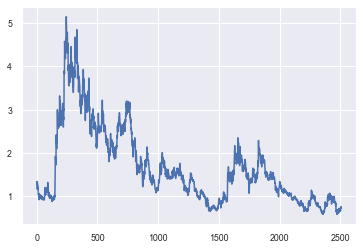

In [170]:
d['AMM.TO']['Close'].plot()

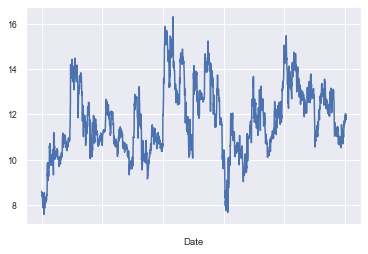

In [168]:
d['ALS.TO'].set_index('Date')['Close'].plot()

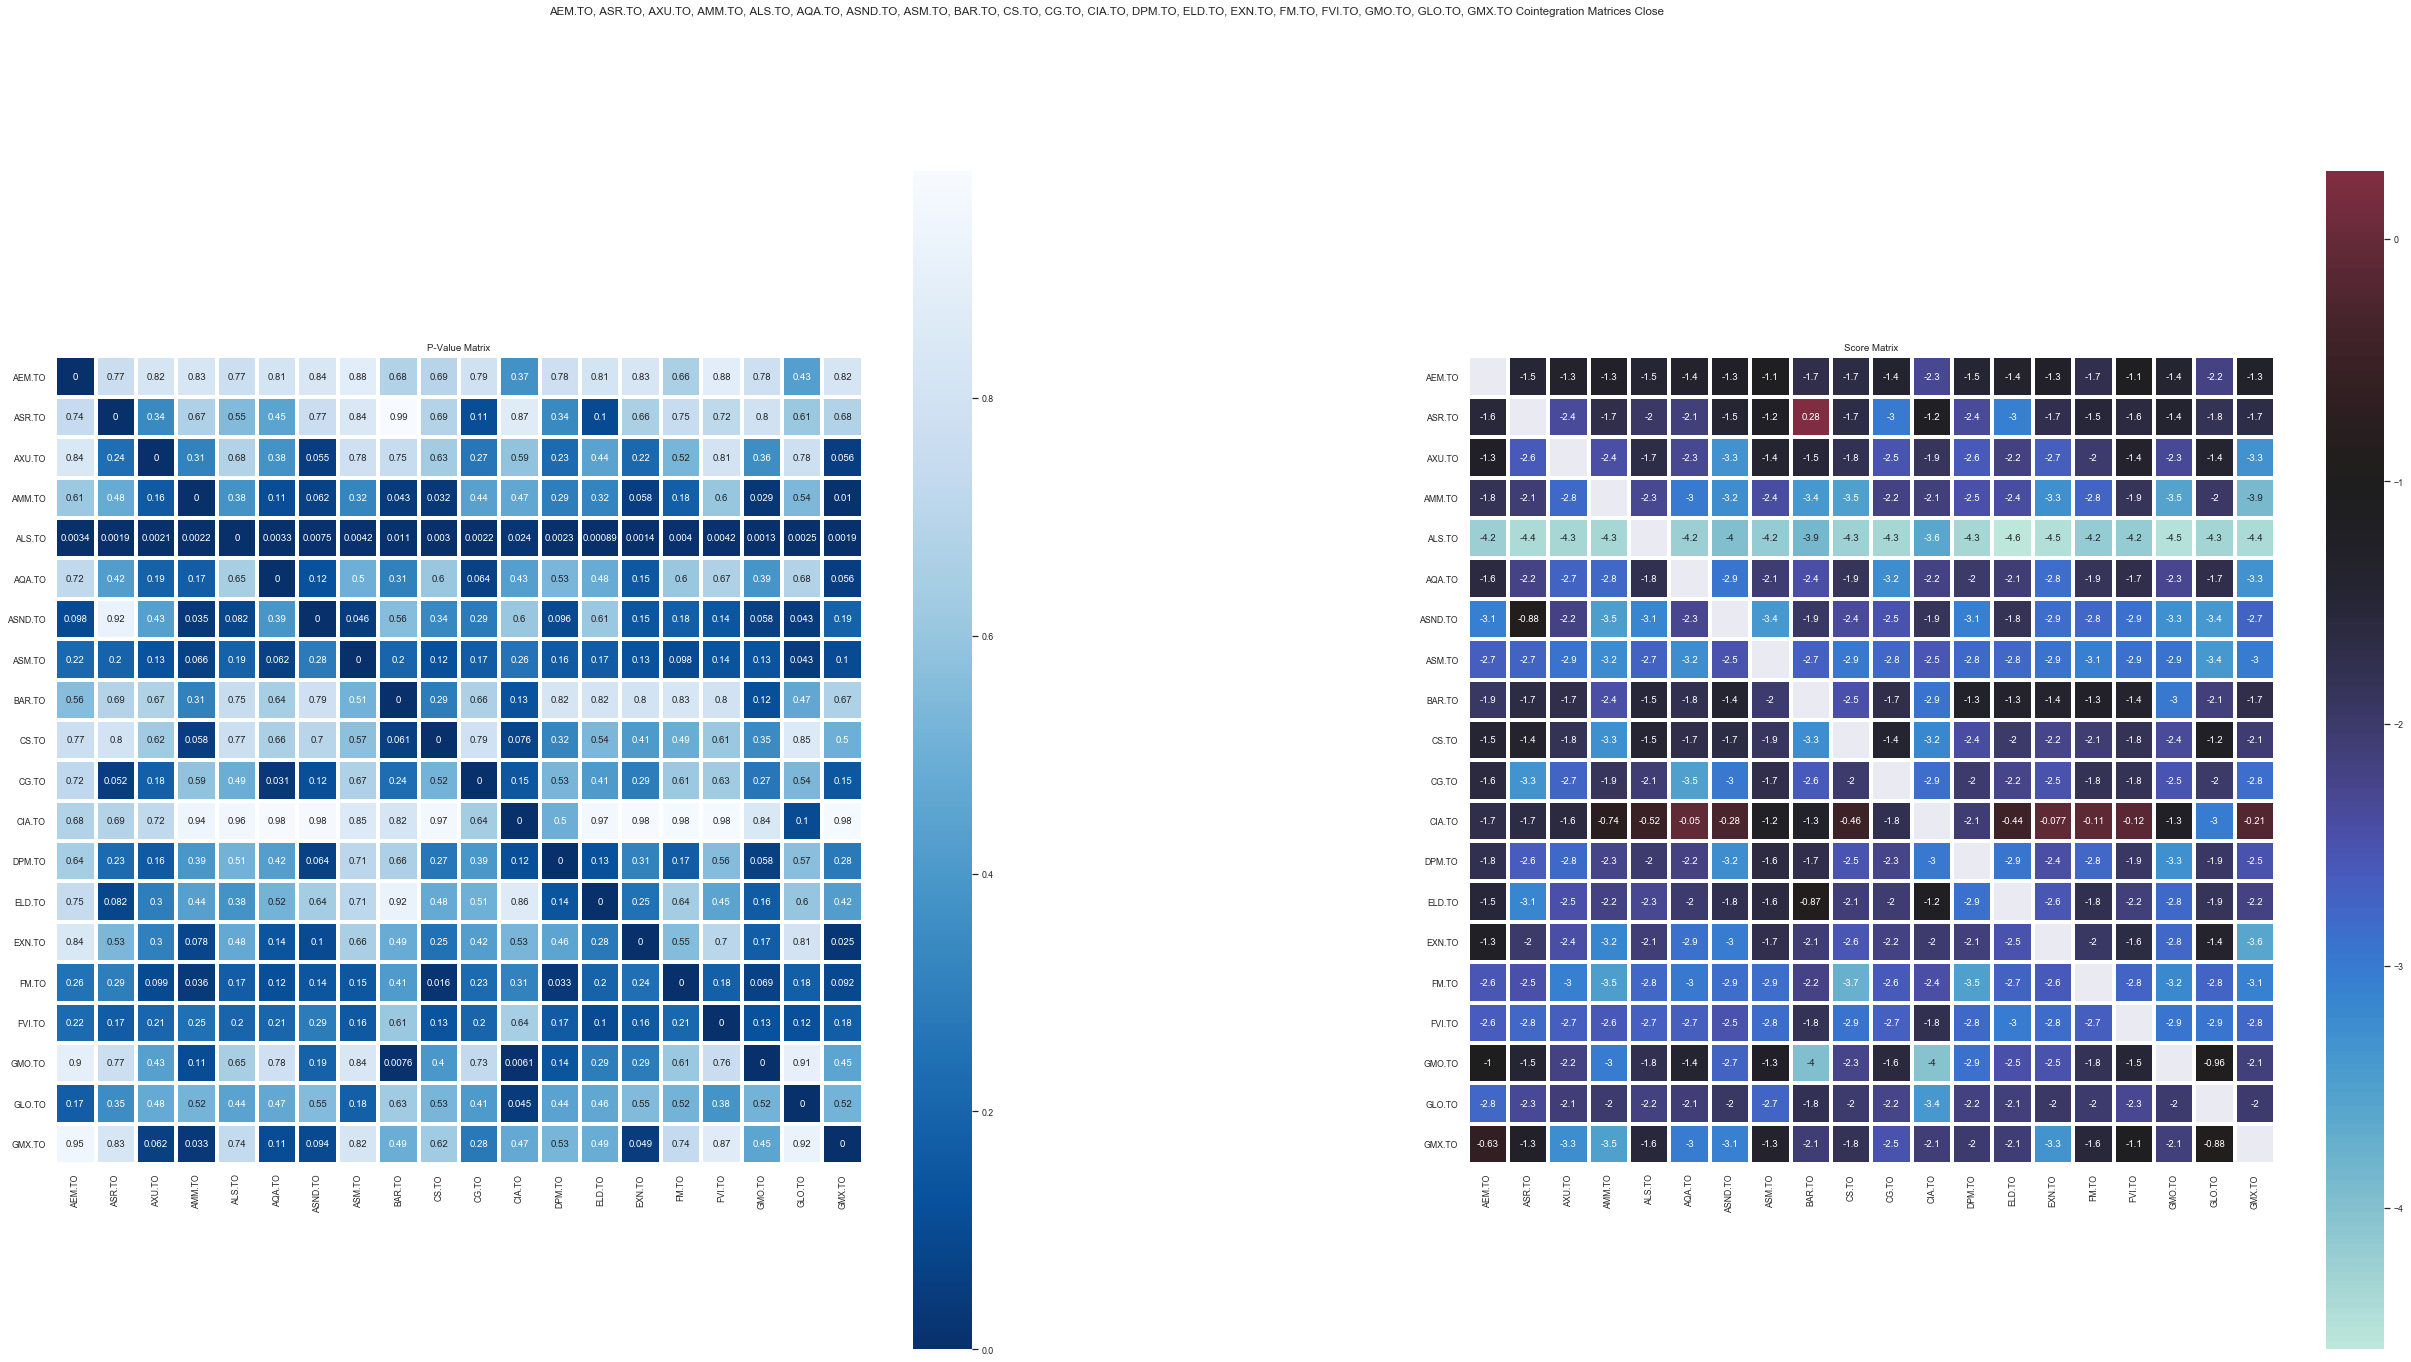

In [141]:
pvalue_matrix, score_matrix, labels = cointegrate_stocks(d, column='Adj Close')
coint_matrix_heatmap(pvalue_matrix, score_matrix, labels)

In [169]:
#CHECK MOST BROWNIAN STOCKS

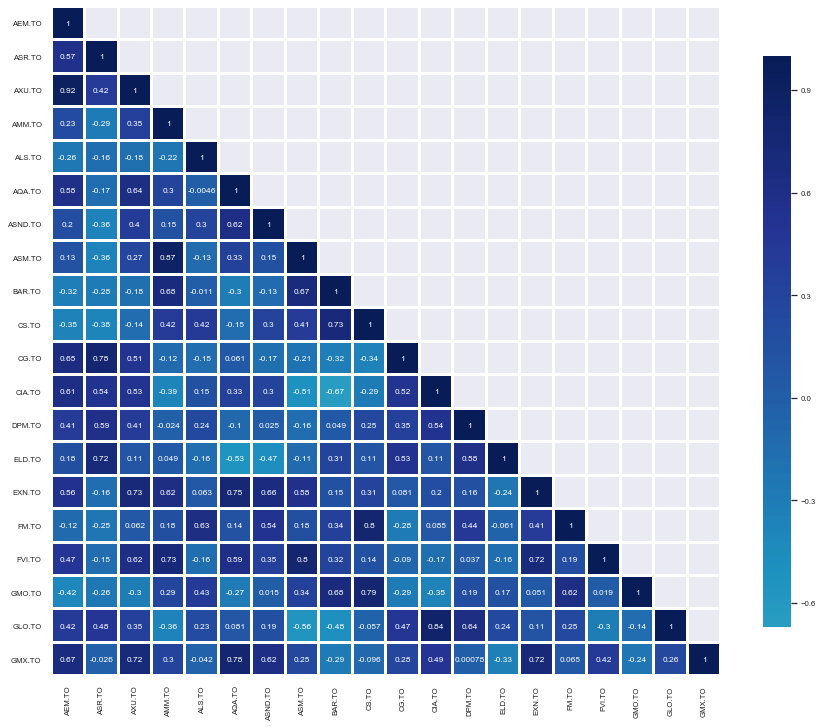

In [112]:
c = correlate_stocks(d, 'Open')
corr_matrix_heatmap(c[0], c[1])

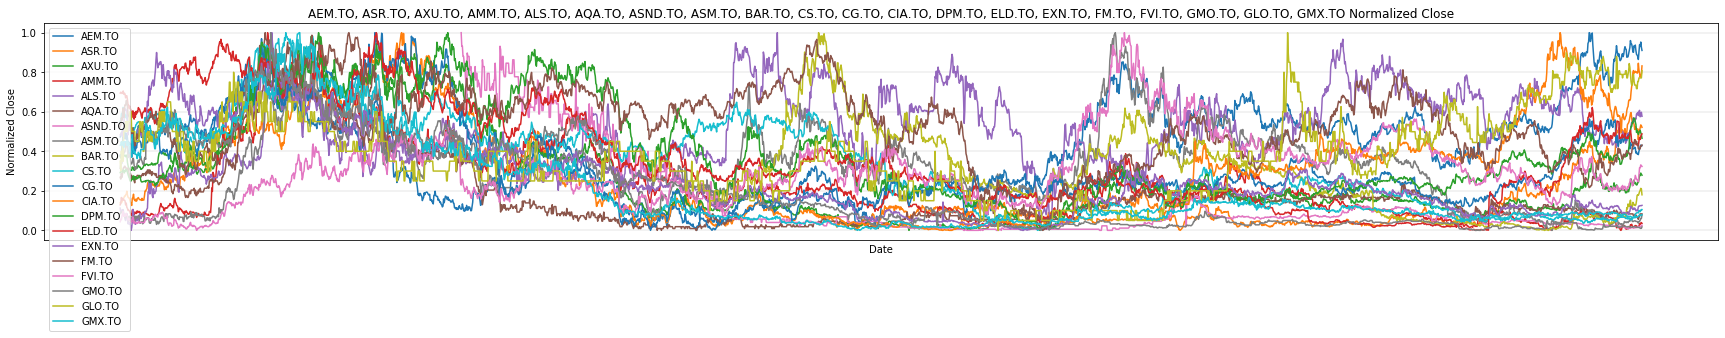

In [57]:
plot_data_list(d, 'Normalized Close')

In [429]:
len(pvalue_matrix)

5

2.4193310737609863


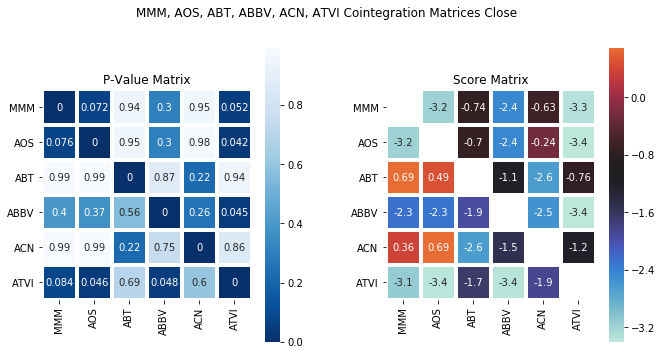

In [442]:
start = time.time()
test = resource_data_list(sp_tickers[:6])
pvalue_matrix, score_matrix, labels = cointegrate_stocks(test, column='Adj Close')
coint_matrix_heatmap(pvalue_matrix, score_matrix, labels)
end = time.time()
print(end - start)

In [30]:
"""volatility surface (delta time volatility) 
bollinger bands dont necessarily work long term"""

'volatility surface (delta time volatility) \nbollinger bands dont necessarily work long term'

In [160]:
# Trade using a simple strategy
def z_score_series(series):
    return (series - series.mean()) / np.std(series)

def z_score_norm_list(series, lower, upper):
    z_norm = [lower + (upper - lower) * x for x in series]
    
    return z_norm

def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 1000
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
    
    
    r = S1 / S2
    z = z_score_series(r)
    #z_norm = pd.Series(z_score_norm_list(z, min(z), max(z)), z.index)
    plt.figure(figsize=(15,7))
    r.plot()
    buy = r.copy()
    sell = r.copy()
    buy[z>-.5] = 0
    sell[z<.5] = 0
    buy[60:].plot(color='g', linestyle='None', marker='^')
    sell[60:].plot(color='r', linestyle='None', marker='^')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,r.min(),r.max()))
    plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
    plt.show()
            
    return money, z

In [ ]:
test_df = 

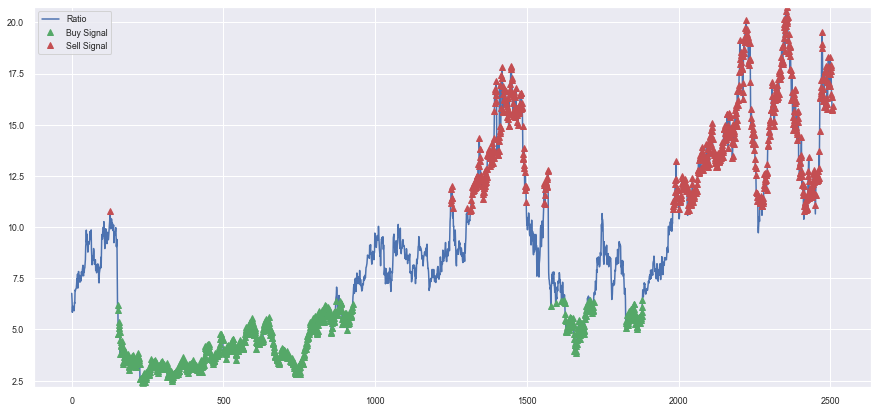

In [164]:
money, z = trade(d['ALS.TO']['Adj Close'], d['AMM.TO']['Adj Close'], 62, 20)

In [165]:
money

1302.8251647559932

In [24]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt

In [ ]:
class MiningPairsTrade(bt.Strategy):
    params = {
        period=10,
        printout=True,
        portfolio_value=100000
    }
    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))
    
    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return
        
        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)
                
        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log
        
        # Allow new orders
        self.orderid = None
        
    
    
    
    
    
    

In [ ]:
class PairsTrade(bt.Strategy):
    params = (("printlog", False), ("quantity", 1000))

    def log(self, txt, dt=None, doprint=False):
        """Logging function for strategy"""
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.delta = 0.0001
        self.Vw = self.delta / (1 - self.delta) * np.eye(2)
        self.Ve = 0.001

        self.beta = np.zeros(2)
        self.P = np.zeros((2, 2))
        self.R = np.zeros((2, 2))

        self.position_type = None  # long or short
        self.quantity = self.params.quantity

    def next(self):

        x = np.asarray([self.data0[0], 1.0]).reshape((1, 2))
        y = self.data1[0]

        self.R = self.P + self.Vw  # state covariance prediction
        yhat = x.dot(self.beta)  # measurement prediction

        Q = x.dot(self.R).dot(x.T) + self.Ve  # measurement variance

        e = y - yhat  # measurement prediction error

        K = self.R.dot(x.T) / Q  # Kalman gain

        self.beta += K.flatten() * e  # State update
        self.P = self.R - K * x.dot(self.R)

        sqrt_Q = np.sqrt(Q)

        if self.position:
            if self.position_type == "long" and e > -sqrt_Q:
                self.close(self.data0)
                self.close(self.data1)
                self.position_type = None
            if self.position_type == "short" and e < sqrt_Q:
                self.close(self.data0)
                self.close(self.data1)
                self.position_type = None

        else:
            if e < -sqrt_Q:
                self.sell(data=self.data0, size=(self.quantity * self.beta[0]))
                self.buy(data=self.data1, size=self.quantity)

                self.position_type = "long"
            if e > sqrt_Q:
                self.buy(data=self.data0, size=(self.quantity * self.beta[0]))
                self.sell(data=self.data1, size=self.quantity)
                self.position_type = "short"

        self.log(f"beta: {self.beta[0]}, alpha: {self.beta[1]}")

In [194]:
startdate = datetime(2017, 1, 1)
enddate = datetime(2020, 1, 1)

# Add the Data Feed to Cerebro


AVL = bt.feeds.YahooFinanceData(dataname="AVL.TO", fromdate=startdate, todate=enddate)
ORL = bt.feeds.YahooFinanceData(dataname="ORL.TO", fromdate=startdate, todate=enddate)

In [26]:
def run():
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100000.0)
    cerebro.addstrategy(PairsTrade)
    
    startdate = datetime(2017, 1, 1)
    enddate = datetime(2020, 1, 1)

    # Add the Data Feed to Cerebro


    AVL = bt.feeds.YahooFinanceData(dataname="AVL.TO", fromdate=startdate, todate=enddate)
    ORL = bt.feeds.YahooFinanceData(dataname="ORL.TO", fromdate=startdate, todate=enddate)

    cerebro.adddata(AVL)
    cerebro.adddata(ORL)
    # cerebro.broker.setcommission(commission=0.0001)
    
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    
    
    cerebro.run()
    

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [ ]:
# look at when series goes down correlate that